I'm currently taking part in a MOOC called [Computers, Waves and Simulations](https://www.coursera.org/learn/computers-waves-simulations). It is about numerical methods for wave equations. So far, it seems really well designed. In week 2, the content focuses on finite difference methods. 

In particular, the course introduces a very general method for deriving high-order stencils of derivatives by solving a linear system. In this post, I try to reproduce the method using a symbolic approach, while the class example focused on a numerical approach.

We will start by solving the system with numbers and then move on to solve it symbolically.

# Deriving a fourth order accurate approximation of a second derivative 

One of the exercices in the online class is to derive a fourth order accurate expression for the second derivative, using the value of the function at points: $x-2dx, x-dx, x, x+dx, +2dx$. After writing the Taylor expansion at each of these points, they are combined to form an approximation for the derivative.

Let's follow along and start with the matrix obtained in the exercise.

In [1]:
from sympy import *

weight_matrix = Matrix([[1,  1, 1,  1,  1],
                 [2,  1, 0, -1, -2],
                 [4,  1, 0,  1,  4],
                 [8,  1, 0, -1, -8],
                 [16, 1, 0,  1, 16]])

weight_matrix

Matrix([
[ 1, 1, 1,  1,  1],
[ 2, 1, 0, -1, -2],
[ 4, 1, 0,  1,  4],
[ 8, 1, 0, -1, -8],
[16, 1, 0,  1, 16]])

What does this matrix mean? Each column represents the Taylor expansion at one of the points as a function of $\frac{dx^i}
{i!}f^{(i)}(x)$ (each row coefficient).

This matrix can then be inverted:

In [2]:
weight_matrixinv = weight_matrix.inv()

weight_matrixinv

Matrix([
[0, -1/12, -1/24,  1/12, 1/24],
[0,   2/3,   2/3,  -1/6, -1/6],
[1,     0,  -5/4,     0,  1/4],
[0,  -2/3,   2/3,   1/6, -1/6],
[0,  1/12, -1/24, -1/12, 1/24]])

Now we can easily solve for interesting solutions. Setting the first coefficient to one in the solution vector should give us a fourth order accurate approximation to $f(x)$:

In [3]:
weight_matrixinv.multiply(Matrix([1, 0, 0, 0, 0]))

Matrix([
[0],
[0],
[1],
[0],
[0]])

Recalling that the above are coefficients for the sampled points, we can go further and multiply the inverted solution by the function values:

In [4]:
x, h = symbols('x, h')
f = Function('f')

approx_points = Matrix([f(x+2*h), f(x+h), f(x), f(x-h), f(x-2*h)])

weight_matrixinv.multiply(Matrix([1, 0, 0, 0, 0])).multiply_elementwise(approx_points).T

Matrix([[0, 0, f(x), 0, 0]])

We can apply the same reasoning to obtain fourth order versions of the other derivatives.

First derivative:

In [5]:
weight_matrixinv.multiply(Matrix([0, 1/h, 0, 0, 0])).multiply_elementwise(approx_points).T

Matrix([[-f(2*h + x)/(12*h), 2*f(h + x)/(3*h), 0, -2*f(-h + x)/(3*h), f(-2*h + x)/(12*h)]])

Second derivative:

In [6]:
weight_matrixinv.multiply(Matrix([0, 0, factorial(2)/h**2, 0, 0])).multiply_elementwise(approx_points).T

Matrix([[-f(2*h + x)/(12*h**2), 4*f(h + x)/(3*h**2), -5*f(x)/(2*h**2), 4*f(-h + x)/(3*h**2), -f(-2*h + x)/(12*h**2)]])

Third derivative:

In [7]:
weight_matrixinv.multiply(Matrix([0, 0, 0, factorial(3)/h**3, 0])).multiply_elementwise(approx_points).T

Matrix([[f(2*h + x)/(2*h**3), -f(h + x)/h**3, 0, f(-h + x)/h**3, -f(-2*h + x)/(2*h**3)]])

Fourth derivative.

In [8]:
weight_matrixinv.multiply(Matrix([0, 0, 0, 0, factorial(4)/h**4])).multiply_elementwise(approx_points).T

Matrix([[f(2*h + x)/h**4, -4*f(h + x)/h**4, 6*f(x)/h**4, -4*f(-h + x)/h**4, f(-2*h + x)/h**4]])

# Deriving the stencil with a formal Taylor expansion

As you may have noticed, we started with a matrix of integers and derived the stencils from there. Can we obtain the same matrix, but keep it symbolic? We can! Let's do this using `sympy`.

(as a side note, I found this discussion helpful: https://stackoverflow.com/questions/16869587/how-to-do-a-symbolic-taylor-expansion-of-an-unknown-function-fx-using-sympy)

We first write a function that generates a Taylor expansion up to order $n$:

In [9]:
x, h = symbols('x, h')
f = Function('f')

def TaylorExpansion(point=h, order=4):
    return sum(point**i/factorial(i) * f(x).diff(x, i) for i in range(order+1))

In [10]:
TaylorExpansion(h, 2)

h**2*Derivative(f(x), (x, 2))/2 + h*Derivative(f(x), x) + f(x)

In [11]:
TaylorExpansion(h, 5)

h**5*Derivative(f(x), (x, 5))/120 + h**4*Derivative(f(x), (x, 4))/24 + h**3*Derivative(f(x), (x, 3))/6 + h**2*Derivative(f(x), (x, 2))/2 + h*Derivative(f(x), x) + f(x)

The nice thing about this is that we can use the same function to generate an expansion at a point away, let's say $x + 2h$:

In [12]:
expansion = TaylorExpansion(2*h, 4)
expansion

2*h**4*Derivative(f(x), (x, 4))/3 + 4*h**3*Derivative(f(x), (x, 3))/3 + 2*h**2*Derivative(f(x), (x, 2)) + 2*h*Derivative(f(x), x) + f(x)

Finally, to fill the matrix, all we have to do is take the coefficient that's before a derivative. We can use the `.coeff` method for that:

In [13]:
expansion.coeff(f(x).diff(x, 3))

4*h**3/3

Using the above ideas, we can now:

- generate a Taylor expansion at each point of the grid
- put the coefficient for each derivative of that expansion in a matrix
- invert that matrix to find accurate stencils

Let's write a prototype for order 4:

In [14]:
import numpy as np

n_points = 5
grid_points = np.arange(-(n_points-1)/2, (n_points-1)/2 + 1).astype(int)
order = 4

coef_matrix = ZeroMatrix(n_points, n_points).as_mutable()

for p, h_coef in zip(range(n_points), grid_points):
    
    expansion = TaylorExpansion(h_coef * h, order)
    
    for derivative in range(order + 1):
        term =  f(x).diff(x, derivative)
        coef_matrix[derivative, p] = expansion.coeff(term)

coef_matrix

Matrix([
[        1,       1, 1,       1,        1],
[     -2*h,      -h, 0,       h,      2*h],
[   2*h**2,  h**2/2, 0,  h**2/2,   2*h**2],
[-4*h**3/3, -h**3/6, 0,  h**3/6, 4*h**3/3],
[ 2*h**4/3, h**4/24, 0, h**4/24, 2*h**4/3]])

Now we can just solve for the second derivative by inverting that matrix.

In [15]:
(coef_matrix.inv() @ Matrix([0, 0, 1, 0, 0])).T

Matrix([[-1/(12*h**2), 4/(3*h**2), -5/(2*h**2), 4/(3*h**2), -1/(12*h**2)]])

This is exactly the expression we had before. Our little algorithm works!

# Stencils for the second derivative

Now, let's extend that procedure by adding even higher order terms and let's focus on the second derivative stencil.

In [16]:
def compute_second_derivative_stencil(n_points, order=4):
    """Returns a `order` accurate stencil for the second derivative."""

    grid_points = np.arange(-(n_points-1)/2, (n_points-1)/2 + 1).astype(int)

    coef_matrix = ZeroMatrix(n_points, n_points).as_mutable()

    for p, h_coef in zip(range(n_points), grid_points):

        expansion = TaylorExpansion(h_coef * h, order)

        for derivative in range(order + 1):
            term =  f(x).diff(x, derivative)
            coef_matrix[derivative, p] = expansion.coeff(term)
    
    second_derivative_vector = ZeroMatrix(order + 1, 1).as_mutable()
    second_derivative_vector[2, 0] = 1

    return coef_matrix.inv() @ second_derivative_vector

In [17]:
compute_second_derivative_stencil(n_points=5).T

Matrix([[-1/(12*h**2), 4/(3*h**2), -5/(2*h**2), 4/(3*h**2), -1/(12*h**2)]])

In [18]:
compute_second_derivative_stencil(n_points=7, order=6).T

Matrix([[1/(90*h**2), -3/(20*h**2), 3/(2*h**2), -49/(18*h**2), 3/(2*h**2), -3/(20*h**2), 1/(90*h**2)]])

Let's now do the plots.

In [19]:
stencils = []
for n_points in [3, 5, 7, 9, 11, 13]:
    x_grid = np.arange(-(n_points-1)/2, (n_points-1)/2 + 1).astype(int)
    stencil = compute_second_derivative_stencil(n_points, order=n_points-1)
    stencils.append((x_grid, stencil))

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

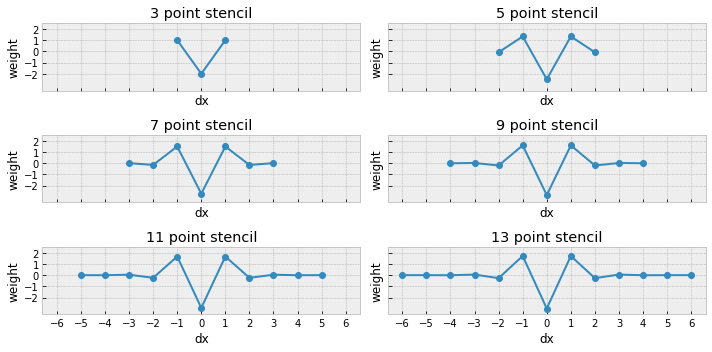

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(10, 5))
for ind, (x_grid, stencil) in enumerate(stencils):
    current_ax = ax.flatten()[ind]
    current_ax.plot(x_grid, np.array((stencil * h**2)).astype(float), '-o')
    current_ax.set_title(f"{len(x_grid)} point stencil")
    current_ax.set_xlabel('dx')
    current_ax.set_ylabel('weight')
    current_ax.set_xticks(np.arange(-6, 7))
    current_ax.set_yticks(np.arange(-2, 3))
    current_ax.set_ylim(-3.5, 2.5)
plt.tight_layout()

An important feature of this graph is that the more points you add, the smaller the edge coefficients get. A relevant question then is: what is the right stencil size? 

# Finite difference stencils at the edge of a mesh 

What I like about the "automatic" method described in this post is that it can also help to derive accurate stencils for edges of meshes. Admittedly, this is primarily relevant in 1D, but I remember [working on the 1D heat equation](http://flothesof.github.io/heat-equation-cook-my-meat.html) and wondering how to have accurate stencils at the edges. 

The example we're going to look at comes from these course notes:
http://iacs-courses.seas.harvard.edu/courses/am205/notes/am205_fd_stencil.pdf

The problem is to find a second order accurate stencil for the derivative at the left edge of a 1D mesh. We can build a solution reusing the previously written code.

In [22]:
grid_points = [0, 1, 2]
order = 2
coef_matrix = ZeroMatrix(order + 1, len(grid_points)).as_mutable()

for p, h_coef in enumerate(grid_points):
    expansion = TaylorExpansion(h_coef * h, order)
    for derivative in range(order + 1):
        term =  f(x).diff(x, derivative)
        coef_matrix[derivative, p] = expansion.coeff(term)

coef_matrix

Matrix([
[1,      1,      1],
[0,      h,    2*h],
[0, h**2/2, 2*h**2]])

Let's now use this to find the solution that gives a vector of [0, 1, 0].

In [23]:
approx_vector = Matrix([f(x + h_coef * h) for h_coef in grid_points])

(coef_matrix.inv() @ Matrix([0, 1, 0])).T @ approx_vector 

Matrix([[-3*f(x)/(2*h) + 2*f(h + x)/h - f(2*h + x)/(2*h)]])

Great! This is the same solution as the PDF.

We can go even further by adding points and derive a third order accurate stencil.

In [24]:
grid_points = [0, 1, 2, 3]
order = 3
coef_matrix = ZeroMatrix(order + 1, len(grid_points)).as_mutable()

for p, h_coef in enumerate(grid_points):
    expansion = TaylorExpansion(h_coef * h, order)
    for derivative in range(order + 1):
        term =  f(x).diff(x, derivative)
        coef_matrix[derivative, p] = expansion.coeff(term)
        
coef_matrix

Matrix([
[1,      1,        1,        1],
[0,      h,      2*h,      3*h],
[0, h**2/2,   2*h**2, 9*h**2/2],
[0, h**3/6, 4*h**3/3, 9*h**3/2]])

In [25]:
approx_vector = Matrix([f(x + h_coef * h) for h_coef in grid_points])

(coef_matrix.inv() @ Matrix([0, 1, 0, 0])).T @ approx_vector 

Matrix([[-11*f(x)/(6*h) + 3*f(h + x)/h - 3*f(2*h + x)/(2*h) + f(3*h + x)/(3*h)]])

Or, we can derive a third order accurate stencil for the second derivative.

In [26]:
(coef_matrix.inv() @ Matrix([0, 0, 1, 0])).T @ approx_vector 

Matrix([[2*f(x)/h**2 - 5*f(h + x)/h**2 + 4*f(2*h + x)/h**2 - f(3*h + x)/h**2]])

# Conclusion 

I hope this notebook sheds some light on the linear system method used to derive high order stencils for finite-difference computations. If this sort of thing is interesting for you, check out the [Coursera class](https://www.coursera.org/learn/computers-waves-simulations)!

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20200403_StencilsForFiniteDifferences.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20200403_StencilsForFiniteDifferences.ipynb).*